In [182]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

In [183]:
args = {'lr':0.01,
        'epochs':1000,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'stages':11,
        'hidden size':32
        }

In [184]:
df = pd.read_excel('wide_range.xlsx')

In [185]:
X = df.iloc[:,11:]
y = df.iloc[:,:11]

In [186]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

# add noise
noise = np.random.normal(loc=0, scale=args['noise'], size=X.shape)
X = X + noise

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=args['train size'], random_state=101)

In [188]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [189]:
class HierarchicalNN(nn.Module):
    def __init__(self, input_size, output_size, num_stages, hidden_size):
        super(HierarchicalNN, self).__init__()
        self.num_stages = num_stages

        self.stages = nn.ModuleList()
        for stage in range(self.num_stages):
            if stage == 0:
                # first stage
                stage_network = nn.Sequential(
                    nn.Linear(input_size, hidden_size),
                    nn.ReLU(),
                    nn.Linear(hidden_size, hidden_size),
                    nn.ReLU(),
                    nn.Linear(hidden_size, output_size)
                )
            else:
                # intermediate stages
                stage_network = nn.Sequential(
                    nn.Linear(input_size + output_size, hidden_size),
                    nn.ReLU(),
                    nn.Linear(hidden_size, hidden_size),
                    nn.ReLU(),
                    nn.Linear(hidden_size, output_size)
                )
            self.stages.append(stage_network)

    def forward(self, x):
        outputs = []
        for stage in range(self.num_stages):
            if stage == 0:
                stage_output = self.stages[stage](x)
            else:
                stage_input = torch.cat((x, outputs[stage-1]), dim=1)
                stage_output = self.stages[stage](stage_input)
            outputs.append(stage_output)
        return outputs[-1]

In [190]:
input_size = len(X.columns)
output_size = len(y.columns)
num_stages = args['stages']
hidden_size = args['hidden size']

In [191]:
model = HierarchicalNN(input_size, output_size, num_stages, hidden_size)

In [192]:
print(model)

HierarchicalNN(
  (stages): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=86, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=11, bias=True)
    )
    (1-10): 10 x Sequential(
      (0): Linear(in_features=97, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=11, bias=True)
    )
  )
)


In [193]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])

In [194]:
num_epochs = args['epochs']
losses = []
for epoch in range(num_epochs):
    # forward pass
    outputs = model(X_train_tensor)

    # loss
    loss = criterion(outputs, y_train_tensor)

    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    if (epoch+1) % int(args['epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

epoch: 100, loss = 98.94975280761719
epoch: 200, loss = 15.181595802307129
epoch: 300, loss = 11.578296661376953
epoch: 400, loss = 10.462406158447266
epoch: 500, loss = 9.341842651367188
epoch: 600, loss = 9.838050842285156
epoch: 700, loss = 9.982818603515625
epoch: 800, loss = 9.255685806274414
epoch: 900, loss = 9.618152618408203
epoch: 1000, loss = 9.576909065246582


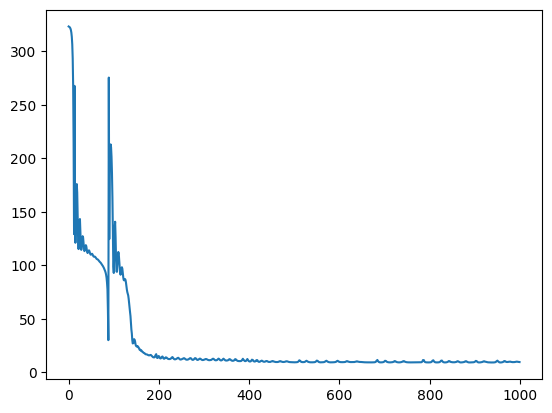

In [195]:
plt.plot(losses)

In [196]:
model.eval()

with torch.no_grad():
    pred = model(X_test_tensor)

    test_loss = criterion(pred, y_test_tensor)

    pred_arr = pred.numpy()
    actual_arr = y_test_tensor.numpy()

print(f'Test Loss: {test_loss.item()}')

Test Loss: 9.646592140197754


In [197]:
def plot_comparison(pred, actual):
    plt.title("Temperature Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("Temperature")
    plt.plot(pred, 'r+', label='predicted')
    plt.plot(actual, 'g', label='actual')
    plt.show()

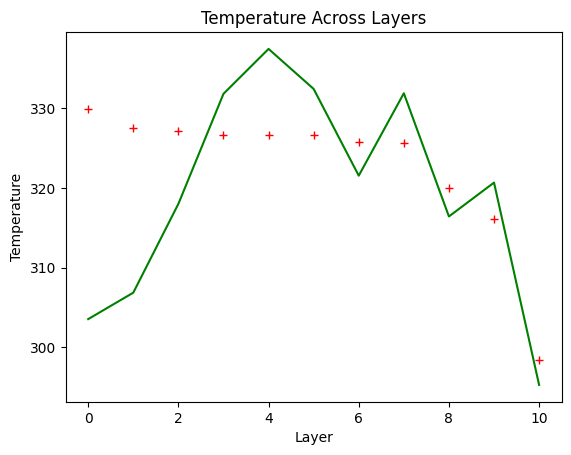

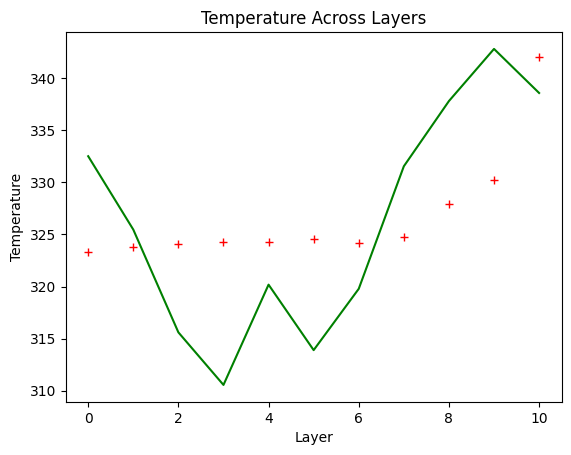

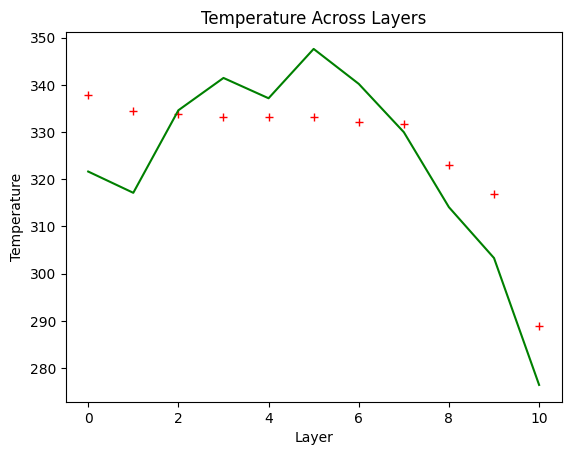

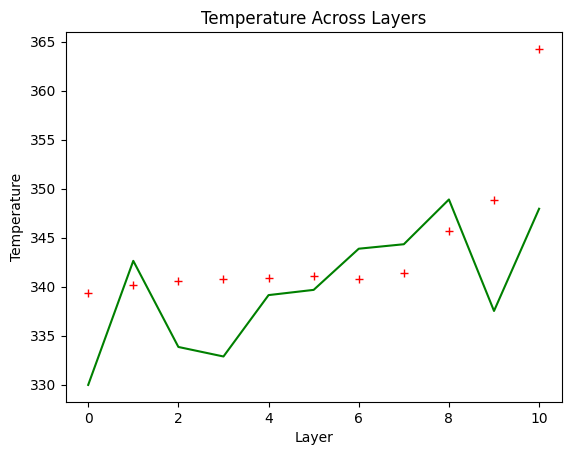

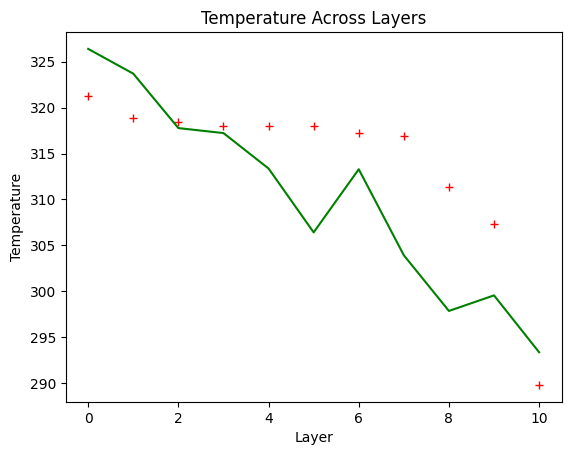

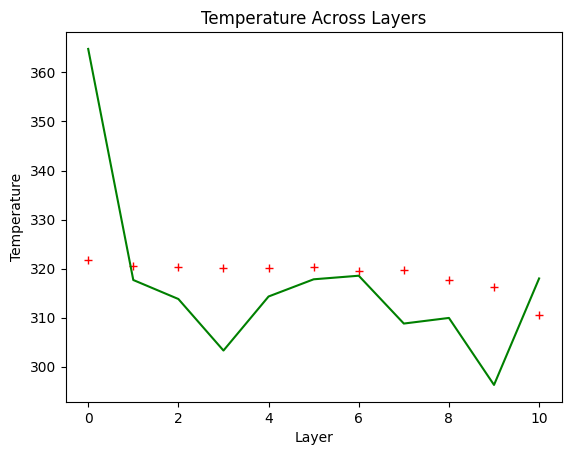

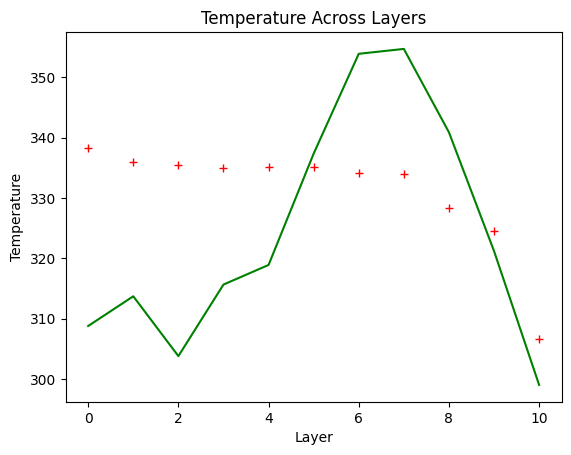

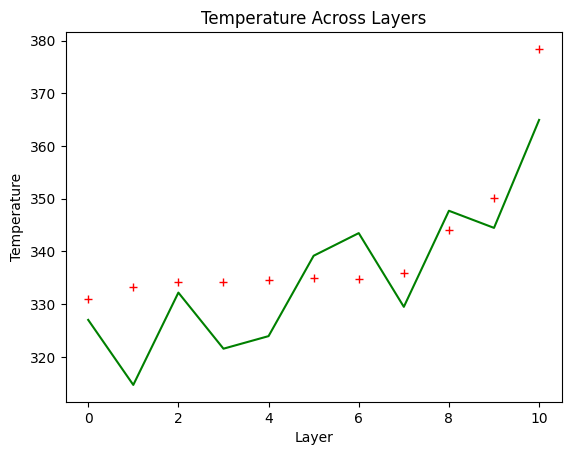

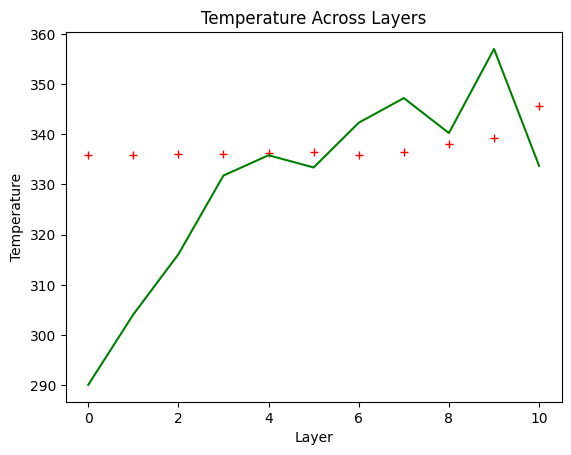

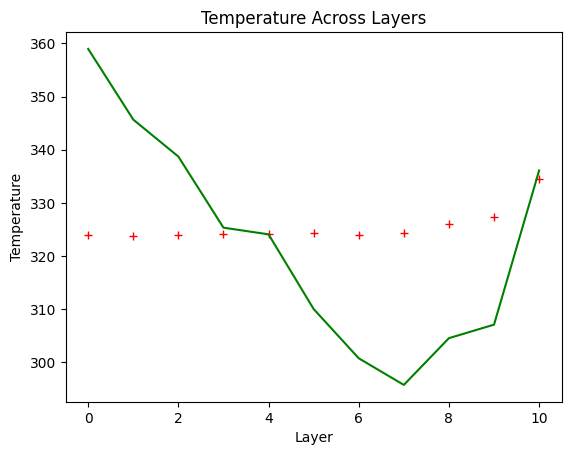

In [198]:
i = 0
while i < len(pred_arr):
    plot_comparison(pred_arr[i], actual_arr[i])
    i += int(len(pred_arr)/10)